In [7]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')


## Data Preprocessing
- Convert 'Month' column to datetime type
- Set 'Month' as index
- Handle missing values (do not remove any rows)


In [8]:
# Load the dataset
df = pd.read_csv("trendkart_sales_data.csv")

# Convert Month to datetime
df['Month'] = pd.to_datetime(df['Month'])

# Set Month as index
df.set_index('Month', inplace=True)

# Check for missing values
print("Missing values:\n", df.isnull().sum())


Missing values:
 Total_Sales           0
Promotions            0
Festive_Season        0
Online_Sales_Ratio    0
dtype: int64


as there are no missing values there is no need to do any handling with the missing data

In [9]:
df.head()

,Total_Sales,Promotions,Festive_Season,Online_Sales_Ratio
Month,,,,
2019-01-01,20745.07,0,0,0.25
2019-02-01,21442.60,0,0,0.35
2019-03-01,23869.61,0,0,0.35
2019-04-01,25734.54,0,0,0.47
2019-05-01,22846.85,1,0,0.34


## Exploratory Data Analysis (EDA)

### Plot raw sales data
To observe overall trend and seasonality.


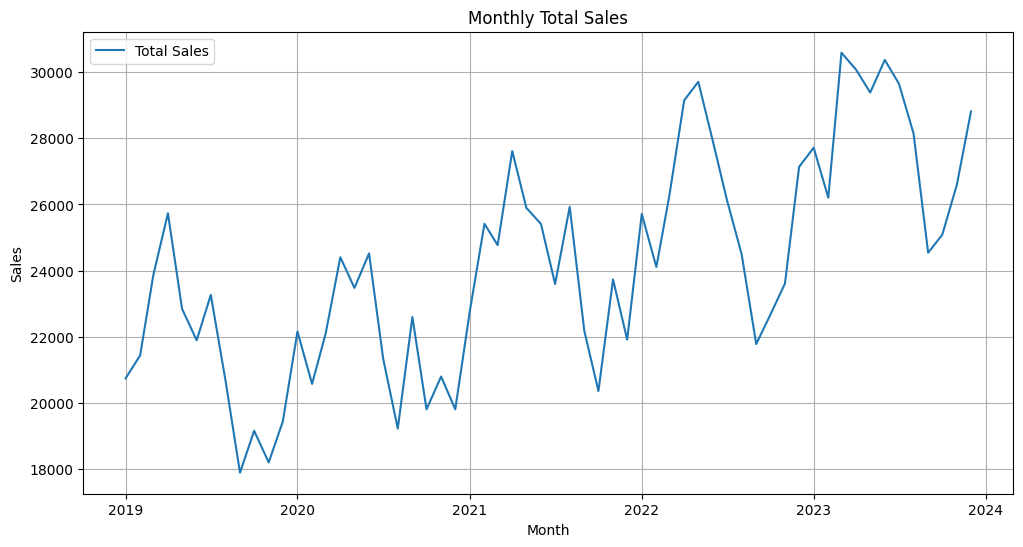

In [10]:
# Plot total sales
plt.figure(figsize=(12, 6))
plt.plot(df['Total_Sales'], label='Total Sales')
plt.title("Monthly Total Sales")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.grid(True)
plt.legend()
plt.show()


### Moving Averages
- 3-month and 12-month moving averages to smooth out noise.


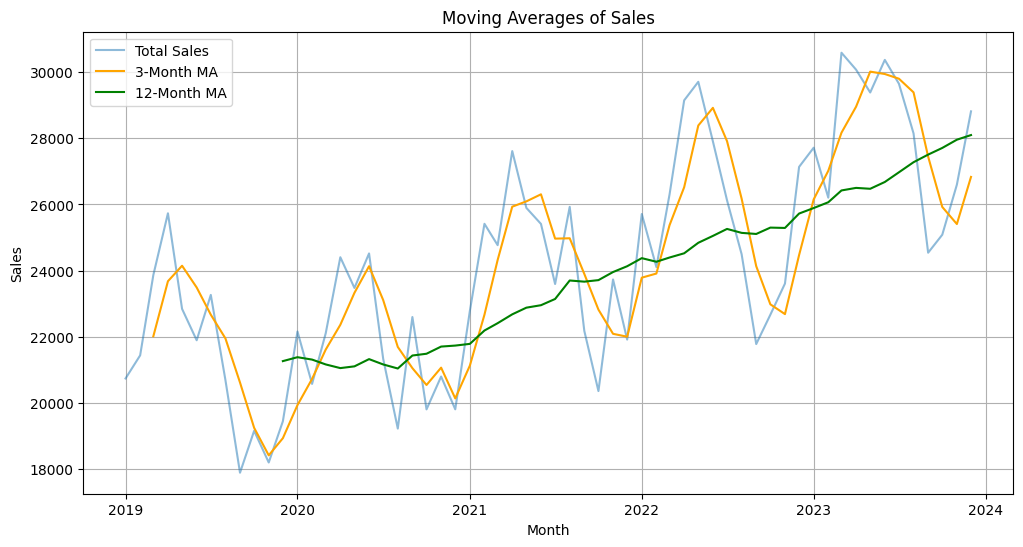

In [11]:
df['MA_3'] = df['Total_Sales'].rolling(window=3).mean()
df['MA_12'] = df['Total_Sales'].rolling(window=12).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['Total_Sales'], label='Total Sales', alpha=0.5)
plt.plot(df['MA_3'], label='3-Month MA', color='orange')
plt.plot(df['MA_12'], label='12-Month MA', color='green')
plt.title("Moving Averages of Sales")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.grid(True)
plt.legend()
plt.show()


### Seasonal Decomposition
Using Seasonal-Trend decomposition using LOESS.


In [12]:
stl = seasonal_decompose(df['Total_Sales'], model='additive')
result.plot()
plt.show()


NameError: name 'result' is not defined

## Stationarity Check
Using Augmented Dickey-Fuller (ADF) Test to check for stationarity.


In [ ]:
adf_result = adfuller(df['Total_Sales'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")


ADF Statistic: 0.8094226831168545
p-value: 0.9917867552700765


## Model Selection and Forecasting

### Train-Test Split
- Use 80% of data for training
- 20% for testing


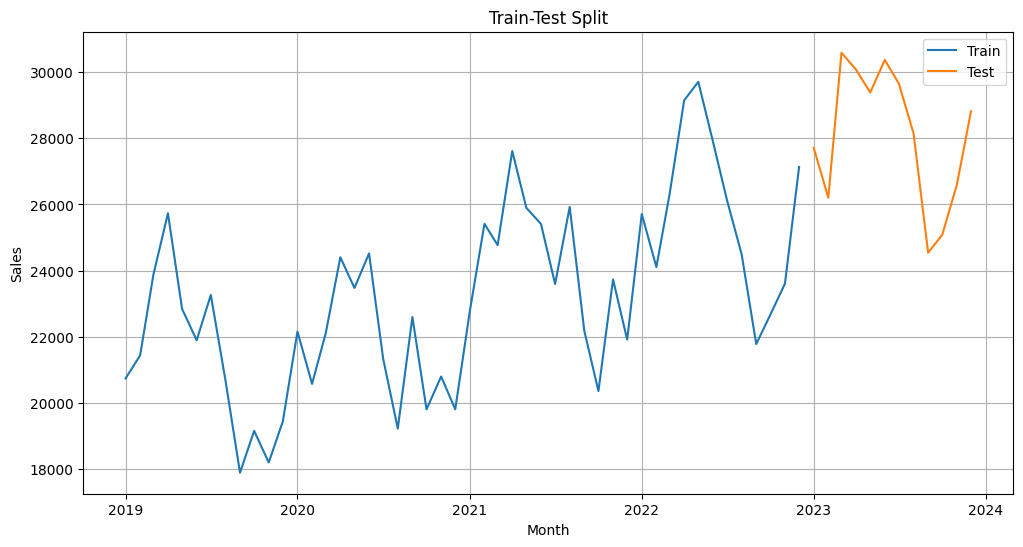

In [13]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Visualize the split
plt.figure(figsize=(12, 6))
plt.plot(train['Total_Sales'], label='Train')
plt.plot(test['Total_Sales'], label='Test')
plt.title("Train-Test Split")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.grid(True)
plt.legend()
plt.show()


### Fit ARIMA Model

In [17]:

arima_model = ARIMA(train['Total_Sales'], order=(2, 1, 2))
arima_result = arima_model.fit()

# Forecast using ARIMA
arima_forecast = arima_result.predict(start=test.index[0], end=test.index[-1])

### Model Evaluation

Evaluate using:
- RMSE (Root Mean Squared Error)
- MAPE (Mean Absolute Percentage Error)
- Visual comparison


In [18]:
arima_rmse = np.sqrt(mean_squared_error(test['Total_Sales'], arima_forecast))
arima_mape = mean_absolute_percentage_error(test['Total_Sales'], arima_forecast)

print(f"ARIMA RMSE: {arima_rmse:.2f}")
print(f"ARIMA MAPE: {arima_mape:.2%}")


ARIMA RMSE: 1979.07
ARIMA MAPE: 6.54%


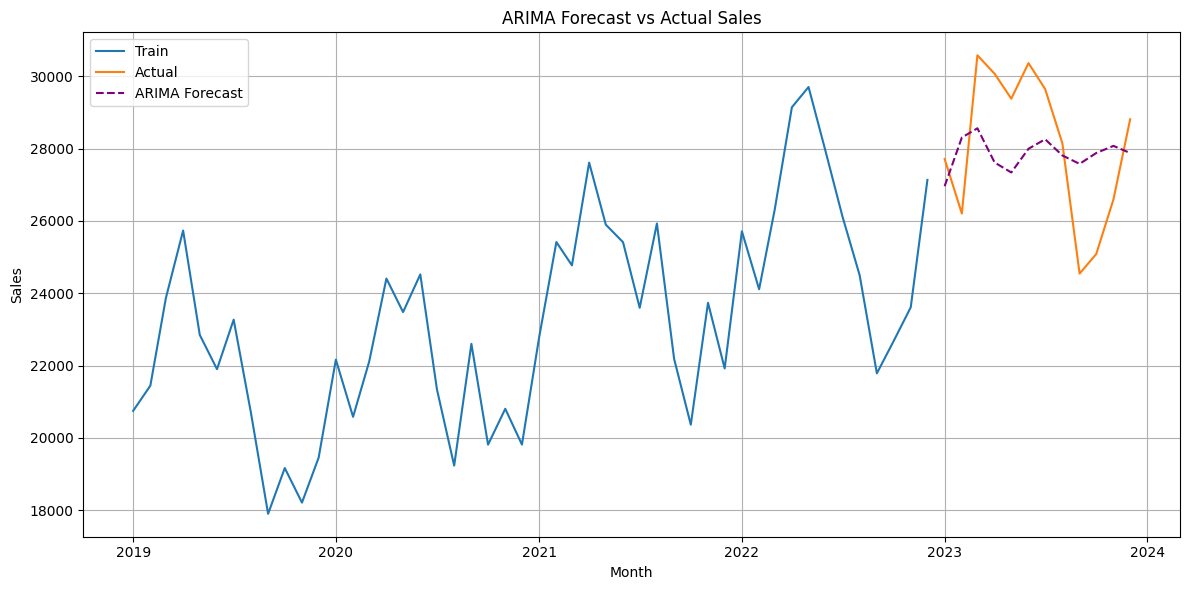

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(train['Total_Sales'], label='Train')
plt.plot(test['Total_Sales'], label='Actual')
plt.plot(arima_forecast, label='ARIMA Forecast', linestyle='--', color='purple')
plt.title("ARIMA Forecast vs Actual Sales")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Fit SARIMA Model


In [14]:
# Fit SARIMA model (manually chosen parameters as example)
model = SARIMAX(train['Total_Sales'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit()

# Forecast
forecast = model_fit.predict(start=test.index[0], end=test.index[-1])


### Model Evaluation

Evaluate using:
- RMSE (Root Mean Squared Error)
- MAPE (Mean Absolute Percentage Error)
- Visual comparison


RMSE: 1159.64
MAPE: 3.58%


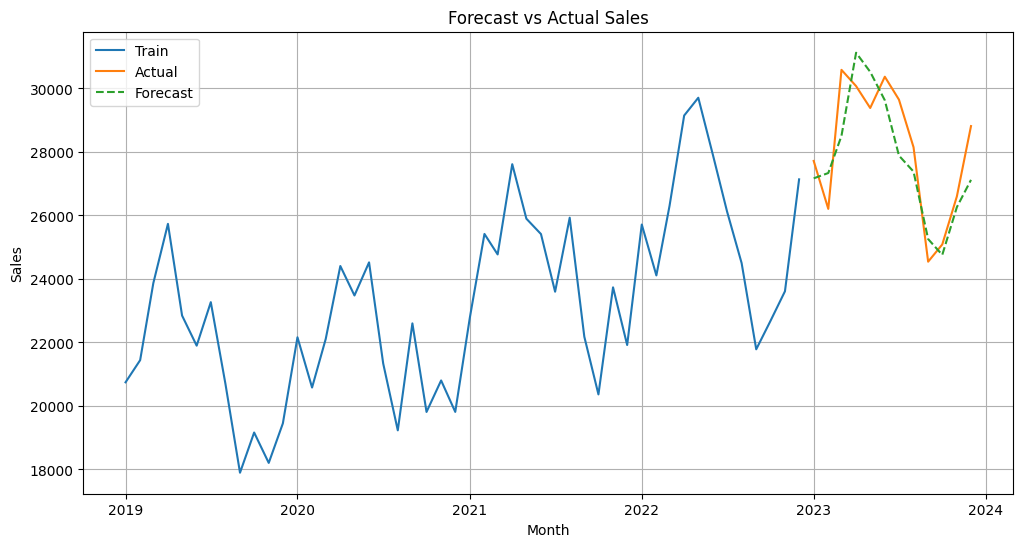

In [15]:
# Evaluation
rmse = np.sqrt(mean_squared_error(test['Total_Sales'], forecast))
mape = mean_absolute_percentage_error(test['Total_Sales'], forecast)

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2%}")

# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(train['Total_Sales'], label='Train')
plt.plot(test['Total_Sales'], label='Actual')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.title("Forecast vs Actual Sales")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.grid(True)
plt.legend()
plt.show()


### ARIMA and SARIMA Comparison

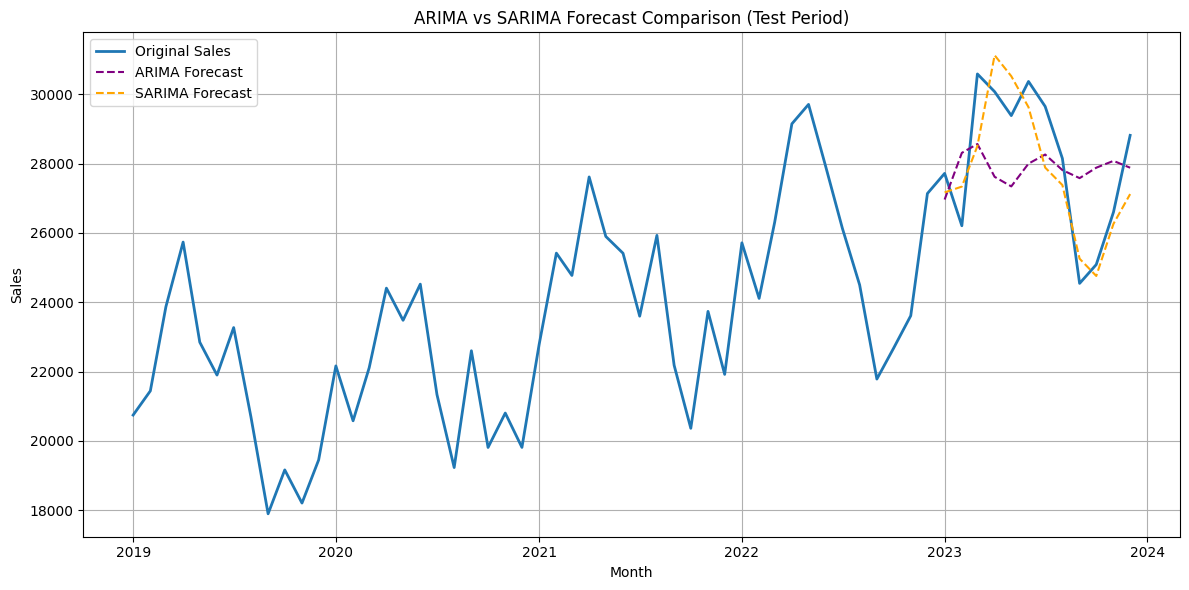

In [24]:
plt.figure(figsize=(12, 6))

# Original full data
plt.plot(df['Total_Sales'], label='Original Sales', linewidth=2)

# Forecast overlays
plt.plot(arima_forecast, label='ARIMA Forecast', linestyle='--', color='purple')
plt.plot(forecast, label='SARIMA Forecast', linestyle='--', color='orange')

# Plot styling
plt.title("ARIMA vs SARIMA Forecast Comparison (Test Period)")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Conclusion

- Successfully visualized and decomposed the time series.
- Identified clear seasonality and trend.
- SARIMA model provided a reasonable forecast with acceptable error metrics.
- This model can help businesses plan inventory and promotions more effectively.
